## Implement Quasiparticle Hamiltonian on a IonQ simulator

In [1]:
import qiskit
import numpy as np
from qiskit.quantum_info import SparsePauliOp

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from typing import Dict


Load matrix elements for $^{18}O$

In [2]:
data_onebody=np.load('data/matrix_elements_h_eff_2body/one_body_nn_p.npz')
keys=data_onebody['keys']
values=data_onebody['values']
n_qubits=3

t_onebody={}

for a,key in enumerate(keys):
    i,j=key
    t_onebody[(i,j)]=values[a]

print(t_onebody)


{(0, 0): -6.2321, (0, 1): 1.0430999999999995, (0, 2): -3.763858685577873, (1, 0): 1.0430999999999995, (1, 1): -6.2321, (1, 2): 3.763858685577873, (2, 0): -3.763858685577873, (2, 1): 3.763858685577873, (2, 2): -2.9203}


#### Build-up $H_Q$

In [3]:
def get_hamiltonian(t_onebody:Dict, n_sites:int):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    XX_tuples=[]
    YY_tuples=[]
    Z_tuples=[]
    I_tuples=[]
    for (i,j),t_val in t_onebody.items():
    
        if i==j:
            Z_tuples.append(("Z", [i], -0.5*t_val))
            I_tuples.append(('I',[i],0.5*t_val)) 
        else:
            XX_tuples.append( ("XX", [i, j], 0.25*t_val) )
            YY_tuples.append(("YY", [i, j], 0.25*t_val) )
            
    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*XX_tuples, *YY_tuples,*Z_tuples,*I_tuples], num_qubits=n_sites)
    return hamiltonian.simplify()



Get the manybody basis

In [4]:
import numpy as np
from qiskit.quantum_info import Statevector

n_sites=n_qubits
basis_states = [Statevector.from_label(np.binary_repr(i, width=n_sites)) for i in range(2**n_sites)]

bitstring_to_index = {np.binary_repr(i, width=n_sites): i for i in range(2**n_sites)}
index_to_bitstring = {i: np.binary_repr(i, width=n_sites) for i in range(2**n_sites)}

In [38]:
print(index_to_bitstring)

{0: '000', 1: '001', 2: '010', 3: '011', 4: '100', 5: '101', 6: '110', 7: '111'}


In [4]:
hamiltonian_q=get_hamiltonian(t_onebody=t_onebody,n_sites=n_qubits)




#### Qiskit has the sick problem that the occupation value 1 becomes 0 (they define $S_z$ in the opposite way). Therefore, to select the Hamiltonian fixed in the one quasiparticle many-body basis we need to consider the conversion to the full bitstrig basis 

bitstring_index= 63- $2^{sp \; index}$

In [5]:
from scipy.sparse import csr_matrix



for i in range(1,n_qubits+1):
    for j in range(1,n_qubits+1):
        
        print(f'i={(i-1)},j={(j-1)} ->{csr_matrix(hamiltonian_q.to_matrix())[2**(i-1),2**(j-1)]} \n')
        
### We got exactly the same Hamiltonian!

i=0,j=0 ->(-6.232099999999999+0j) 

i=0,j=1 ->(1.0430999999999995+0j) 

i=0,j=2 ->(-3.763858685577873+0j) 

i=1,j=0 ->(1.0430999999999995+0j) 

i=1,j=1 ->(-6.232099999999999+0j) 

i=1,j=2 ->(3.763858685577873+0j) 

i=2,j=0 ->(-3.763858685577873+0j) 

i=2,j=1 ->(3.763858685577873+0j) 

i=2,j=2 ->(-2.9202999999999992+0j) 



#### Build-up the driver Hamiltonian

In [7]:
coupling_term=-6.232099999999999
Z_tuples=[("Z", [0], -0.5*coupling_term)]
I_tuples=[('I',[0],0.5*coupling_term)]

        
# We create the Hamiltonian as a SparsePauliOp, via the method
# `from_sparse_list`, and multiply by the interaction term.
hamiltonian_driver = SparsePauliOp.from_sparse_list([*Z_tuples,*I_tuples], num_qubits=n_qubits)


print(hamiltonian_driver)

SparsePauliOp(['IIZ', 'III'],
              coeffs=[ 3.11605+0.j, -3.11605+0.j])


In [8]:
from scipy.sparse import csr_matrix



for i in range(1,n_qubits+1):
    for j in range(1,n_qubits+1):
        
        print(f'i={(i-1)},j={(j-1)} ->{csr_matrix(hamiltonian_driver.to_matrix())[2**(i-1),2**(j-1)]} \n')
        

i=0,j=0 ->(-6.232099999999999+0j) 

i=0,j=1 ->0j 

i=0,j=2 ->0j 

i=1,j=0 ->0j 

i=1,j=1 ->0j 

i=1,j=2 ->0j 

i=2,j=0 ->0j 

i=2,j=1 ->0j 

i=2,j=2 ->0j 



#### Define the Parameter Hamiltonian $H(s)=s H_Q + (1-s) H_D$

In [9]:
from qiskit.circuit import Parameter

s = Parameter("s")

hamiltonian_s = s * hamiltonian_q + (1 - s) * hamiltonian_driver



In [10]:
dt=0.1
hamiltonian_eval = hamiltonian_s.assign_parameters({s: dt})


In [13]:
from qiskit.quantum_info import  commutator


# Define the total particle number operator N
z_op = [("Z", [i], -0.5) for i in range(n_qubits)]
identity=[("I", [i], 0.5) for i in range(n_qubits)]
n_operator=SparsePauliOp.from_sparse_list([*z_op,], num_qubits=n_qubits)

# Compute the commutator [H, N]
commutator_result = commutator(hamiltonian_eval, n_operator).simplify()

print(commutator_result)

SparsePauliOp(['III'],
              coeffs=[0j])


#### Let's perform the SUZUKI-TROTTER

In [12]:
from qiskit.synthesis import SuzukiTrotter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import transpile
from qiskit.quantum_info import Statevector
second_order_formula = SuzukiTrotter(order=1)  # if not passed, order defaults to 2
trotter_step_second_order = PauliEvolutionGate(hamiltonian_eval, dt, synthesis=second_order_formula)
circuit = QuantumCircuit(hamiltonian_eval.num_qubits)
circuit.append(trotter_step_second_order, range(hamiltonian_eval.num_qubits))
#circuit = circuit.decompose(reps=2)
circuit_opt=circuit
#circuit_opt = transpile(circuit, optimization_level=1)

#final_state=Statevector(circuit_opt)

initial_state=QuantumCircuit(hamiltonian_eval.num_qubits)
initial_state.x([0])

print(Statevector(initial_state).data)

initial_state.append(circuit_opt,circuit_opt.qubits)
final_state=Statevector(initial_state)

[0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [26]:
#### full time evolution

In [21]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import SuzukiTrotter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import transpile
from qiskit.quantum_info import Statevector


In [160]:

#final_state=Statevector(circuit_opt)
time_steps=10
tf=1
time=np.linspace(0,tf,time_steps)
dt=tf/time_steps
#b=0.8
#h=1-(1+b)*(time/tf)+b*(time/tf)**2
h=1-time/tf
initial_state=QuantumCircuit(hamiltonian_q.num_qubits)
initial_state.x([0])

for n,t in enumerate(time):
    hamiltonian_t=(h[n])*hamiltonian_driver+(1-h[n])*hamiltonian_q
    exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=1))
    initial_state.append(exp_H_t,range(hamiltonian_q.num_qubits))
    

transpiled_initial_state_v0=transpile(initial_state, optimization_level=3)
final_state=Statevector(initial_state)

In [161]:

print(
    f"""
Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: {transpiled_initial_state_v0.depth()}
             Gate count: {len(transpiled_initial_state_v0)}
    Nonlocal gate count: {transpiled_initial_state_v0.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in transpiled_initial_state_v0.count_ops().items()])}

"""
)



# And finall
%matplotlib inline
#initial_state.draw("text")


Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: 64
             Gate count: 82
    Nonlocal gate count: 54
         Gate breakdown: RXX: 27, RYY: 27, RZ: 27, U3: 1




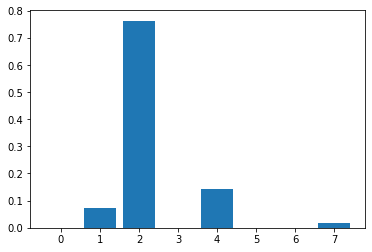

(8,)
(8,)
(8,)


In [162]:
import matplotlib.pyplot as plt



prob=final_state.probabilities()

plt.bar(np.arange(prob.shape[0]),prob)
plt.show()

# convert into the single particle state
single_particle_vector=np.zeros(2**n_qubits,dtype=np.complex128)

for a in range(n_qubits):
    a_mb=2**(a)
    print(final_state.data.shape)
    single_particle_vector[a_mb]=final_state.data[a_mb]
single_particle_vector=single_particle_vector/np.linalg.norm(single_particle_vector) 
final_state_clean_single_particle=Statevector(single_particle_vector)

In [163]:
print(np.linalg.norm(single_particle_vector))
print(np.linalg.norm(final_state.data))
print(final_state.expectation_value(hamiltonian_q)+7.8)

0.9999999999999998
1.000000000000002
(-1.0812791818459262+0j)


In [164]:
from qiskit import transpile

# Define your basis gates
custom_basis_gates = ['cz', 'id', 'rz', 'sx', 'x']

# Transpile your circuit using those gates
transpiled_initial_state = transpile(
    initial_state,  # your circuit here
    basis_gates=custom_basis_gates,
    optimization_level=3  # or 0–3 depending on your needs
)

In [ ]:
transpiled_initial_state.draw()

In [166]:
print(
    f"""
Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: {transpiled_initial_state.depth()}
             Gate count: {len(transpiled_initial_state)}
    Nonlocal gate count: {transpiled_initial_state.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in transpiled_initial_state.count_ops().items()])}

"""
)


Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: 427
             Gate count: 709
    Nonlocal gate count: 108
         Gate breakdown: RZ: 272, SX: 264, CZ: 108, X: 65




#### Ionq simulator

In [ ]:
import os
from qiskit_ionq import IonQProvider


provider = IonQProvider(token="iNarGLptgimgFldYpwMY5x8mTxRZE1C2")
print(provider.backends())

simulator_backend = provider.get_backend("simulator")
simulator_backend.set_options(noise_model="aria-1")

# Create a basic Bell State circuit:


result = simulator_backend.run(initial_state).result()

# Print the counts


#### Simulation quantum Annealing

In [167]:

#final_state=Statevector(circuit_opt)
time_steps=10
tf=1
time=np.linspace(0,tf,time_steps)
dt=tf/time_steps
#b=1.5
#h=1-(1+b)*(time/tf)+b*(time/tf)**2
h=1-time/tf
initial_state=QuantumCircuit(hamiltonian_q.num_qubits)
initial_state.x([0])

for n,t in enumerate(time):
    hamiltonian_t=(h[n])*hamiltonian_driver+(1-h[n])*hamiltonian_q
    exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=1))
    initial_state.append(exp_H_t,range(hamiltonian_q.num_qubits))
    
# Define your basis gates
basis_gates_kingston = ['cz', 'id', 'rz', 'sx', 'x']
basis_gates_eagles= ['ecr', 'id', 'rz', 'sx', 'x']
basis_gates_acheen=['cz', 'id', 'rz', 'rz', 'rzz', 'sx', 'x']
transpiled_initial_state=transpile(initial_state, optimization_level=3,basis_gates=basis_gates_acheen)
final_state=Statevector(initial_state)

#### IBM ibm_aachen

In [168]:
t1 = 225.54 * 1e3  # 225.54 us to ns
t2 = 183.22 * 1e3  # 183.22 us to ns

gate_time_1q = 50   # estimate for single-qubit gates
gate_time_2q = 350  # estimate for two-qubit gates (CZ, RZZ)

from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.errors import thermal_relaxation_error, depolarizing_error, ReadoutError

thermal_1q = thermal_relaxation_error(t1, t2, gate_time_1q)
thermal_2q = thermal_relaxation_error(t1, t2, gate_time_2q)

# Compose with depolarizing error to match median error
sx_error = depolarizing_error(1.840e-4, 1).compose(thermal_1q)
cz_error = depolarizing_error(1.885e-3, 2).compose(thermal_2q)

readout_err = ReadoutError([[1 - 6.836e-3, 6.836e-3], [6.836e-3, 1 - 6.836e-3]])

noise_model = NoiseModel()

for gate in ['sx', 'rx', 'x', 'id']:
    noise_model.add_all_qubit_quantum_error(sx_error, gate)

# CZ and RZZ are both 2-qubit gates; you can add noise to both or just CZ
noise_model.add_all_qubit_quantum_error(cz_error, 'cz')
noise_model.add_all_qubit_quantum_error(cz_error, 'rzz')


#### IBM Eagle noise

In [146]:
t1 = 230.95 * 1e3  # us to ns
t2 = 129.47 * 1e3  # us to ns

gate_time_1q = 50    # ns, estimate for SX, RZ, X gates
gate_time_2q = 300   # ns, estimate for ECR gate


from qiskit_aer.noise.errors import thermal_relaxation_error

thermal_1q = thermal_relaxation_error(t1, t2, gate_time_1q)
thermal_2q = thermal_relaxation_error(t1, t2, gate_time_2q)

from qiskit_aer.noise.errors import depolarizing_error

# SX is single-qubit
sx_error = depolarizing_error(2.476e-4, 1).compose(thermal_1q)

# ECR is two-qubit gate
ecr_error = depolarizing_error(7.294e-3, 2).compose(thermal_2q)

from qiskit_aer.noise import NoiseModel

noise_model = NoiseModel()

# Add errors to basis gates
for gate in ['sx', 'rz', 'x']:
    noise_model.add_all_qubit_quantum_error(sx_error, gate)

noise_model.add_all_qubit_quantum_error(ecr_error, 'ecr')

##### IBM ibm_kingston parameters

In [136]:
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError

# Median calibration data (converted to nanoseconds)
cz_error_rate = 1.911e-3
sx_error_rate = 2.023e-4
readout_error_rate = 8.301e-3
t1 = 284.35e3  # µs -> ns
t2 = 147.16e3  # µs -> ns
gate_time_1q = 35   # ns, typical for SX/RZ/X
gate_time_2q = 200  # ns, rough estimate for CZ

# Create a noise model
noise_model = NoiseModel()

# Add gate errors
cz_depol = depolarizing_error(cz_error_rate, 2)
sx_depol = depolarizing_error(sx_error_rate, 1)
rz_depol = depolarizing_error(1e-5, 1)
x_depol = depolarizing_error(1e-4, 1)

# Add depolarizing errors
noise_model.add_all_qubit_quantum_error(cz_depol, 'cz')
noise_model.add_all_qubit_quantum_error(sx_depol, 'sx')
noise_model.add_all_qubit_quantum_error(rz_depol, 'rz')
noise_model.add_all_qubit_quantum_error(x_depol, 'x')

# Add thermal relaxation errors
thermal_1q = thermal_relaxation_error(t1, t2, gate_time_1q)
thermal_2q = thermal_relaxation_error(t1, t2, gate_time_2q)

for gate in ['sx', 'rz', 'x']:
    noise_model.add_all_qubit_quantum_error(thermal_1q, gate)
#trnoise_model.add_all_qubit_quantum_error(thermal_2q, 'cz')

# Add readout error
# ro_error = ReadoutError([
#     [1 - readout_error_rate, readout_error_rate],
#     [readout_error_rate, 1 - readout_error_rate]
# ])
# noise_model.add_all_qubit_readout_error(ro_error)

# You now have a realistic noise model for a Heron r2-class device

##### Kind of IonQ

In [133]:
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.circuit.library.standard_gates import IGate, XGate, YGate, ZGate, HGate, CXGate

# System parameters (choose Aria 1 here)
r1q = 0.00004     # 1-qubit error rate
r2q = 0.00139     # 2-qubit error rate best performance ever

# Create noise model
noise_model = NoiseModel()

# Define one-qubit depolarizing error
one_qubit_error = depolarizing_error(r1q, 1)

# Define two-qubit depolarizing error
two_qubit_error = depolarizing_error(r2q, 2)

# # Add the one-qubit error to all single-qubit gates


# # Add the two-qubit error to all two-qubit gates (like CX)

    
    
# Assume 0.001 single-qubit error, 0.01 two-qubit error
one_q_error = depolarizing_error(r1q, 1)
two_q_error = depolarizing_error(r2q, 2)

# Add to your favorite gates
#noise_model.add_all_qubit_quantum_error(one_q_error, ['u3'])
#noise_model.add_all_qubit_quantum_error(two_q_error, ['cx'])
for gate in ['cx', 'cz', 'swap']:
    noise_model.add_all_qubit_quantum_error(two_qubit_error, gate)
for gate in ['id', 'x', 'y', 'z', 'h', 's', 't', 'rx', 'ry', 'rz', 'u1', 'u2', 'u3']:
    noise_model.add_all_qubit_quantum_error(one_qubit_error, gate)

#### Simulate with noise

In [169]:
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import Fake5QV1  # or another IBM backend
from qiskit import transpile
from qiskit.quantum_info import DensityMatrix

sim = AerSimulator(noise_model=noise_model)
transpiled_initial_state.save_density_matrix()
# Transpile and run
tqc = transpile(transpiled_initial_state, sim,optimization_level=3)
result = sim.run(tqc).result()



In [ ]:
tqc.draw()

In [170]:
print(
    f"""
Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: {tqc.depth()}
             Gate count: {len(tqc)}
    Nonlocal gate count: {tqc.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in tqc.count_ops().items()])}

"""
)


Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: 82
             Gate count: 130
    Nonlocal gate count: 55
         Gate breakdown: RZZ: 53, RX: 52, RZ: 13, SX: 8, CZ: 2, X: 1, SAVE_DENSITY_MATRIX: 1




In [171]:
# Get the output state vector or density matrix
from qiskit.quantum_info import DensityMatrix,state_fidelity
dm = result.data(0)['density_matrix']
print(dm.shape)
density_matrix_final_state=DensityMatrix(dm)
print(density_matrix_final_state.expectation_value(hamiltonian_q))

(8, 8)
(-8.538947494014874-6.81091875422449e-16j)


/tmp/ipykernel_3790037/3824665734.py:4: DeprecationWarning: The return type of saved density matrices has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.DensityMatrix` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  print(dm.shape)


/tmp/ipykernel_3790037/3999158546.py:4: DeprecationWarning: The return type of saved density matrices has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.DensityMatrix` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  sp_dm[2**(i-1),2**(j-1)]=dm[2**(i-1),2**(j-1)]


<BarContainer object of 8 artists>

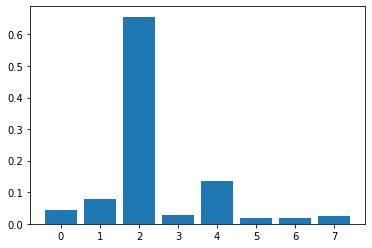

In [172]:
sp_dm=np.zeros((2**n_qubits,2**n_qubits),dtype=np.complex128)
for i in range(1,n_qubits+1):
    for j in range(1,n_qubits+1):
        sp_dm[2**(i-1),2**(j-1)]=dm[2**(i-1),2**(j-1)]

sp_dm=sp_dm/np.trace(sp_dm)
density_matrix_final_state_single_particle=DensityMatrix(sp_dm)

plt.bar(np.arange(2**n_qubits),density_matrix_final_state.probabilities())

(-8.537780525264829+0j) 0.8374208954783713


<BarContainer object of 8 artists>

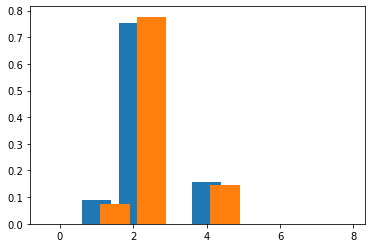

In [173]:
print(density_matrix_final_state_single_particle.expectation_value(hamiltonian_q),state_fidelity(density_matrix_final_state,final_state_clean_single_particle))

plt.bar(np.arange(2**n_qubits),density_matrix_final_state_single_particle.probabilities())
plt.bar(np.arange(2**n_qubits)+0.5,final_state_clean_single_particle.probabilities())


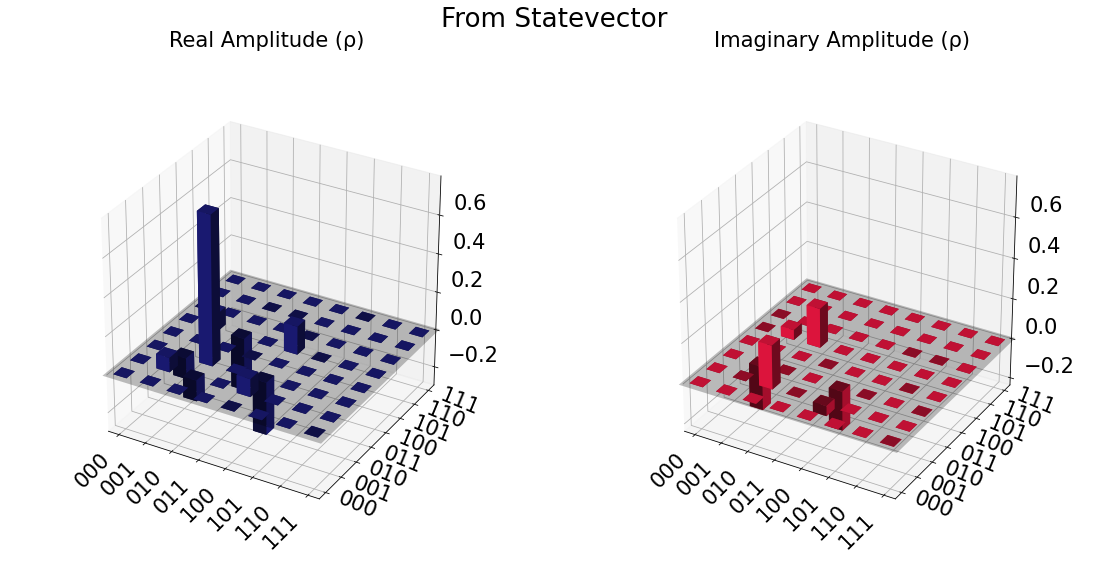

In [174]:
from qiskit.visualization import plot_bloch_vector
from qiskit.quantum_info import Statevector, DensityMatrix

from qiskit.visualization import plot_state_city
# Example state
sv = final_state_clean_single_particle              # |+> = (|0> + |1>)/sqrt(2)
dm = density_matrix_final_state_single_particle       # Completely mixed state


# Convert statevector to density matrix
dm_from_sv = DensityMatrix(sv)

# Plot side-by-side city plots (2D bar graphs)
# Plot first density matrix
plot_state_city(dm_from_sv, title="From Statevector", color=['midnightblue', 'crimson'])



# Plot second (possibly noisy) density matrix


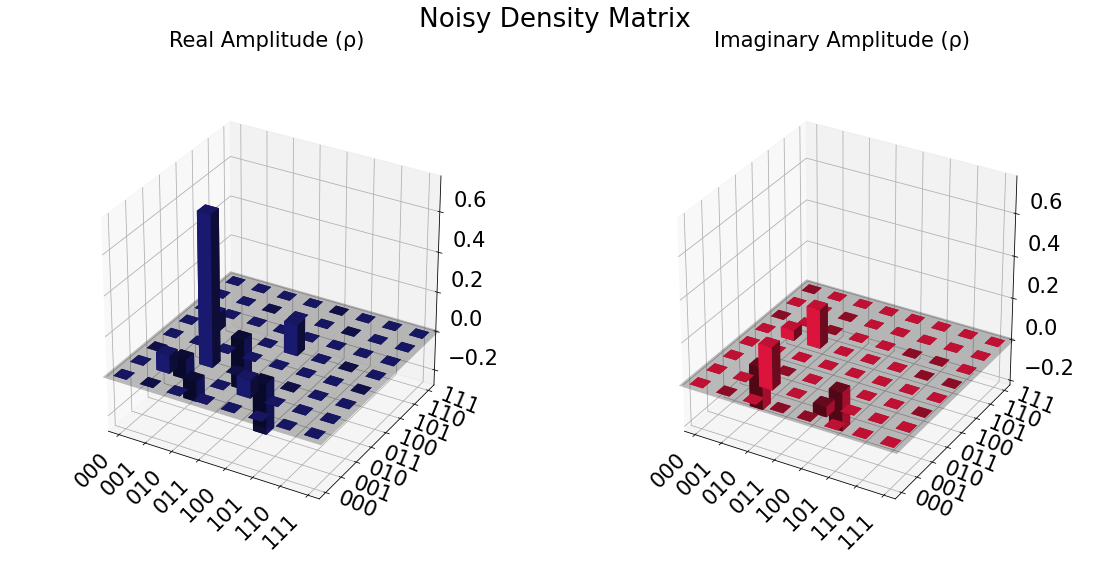

In [175]:
plot_state_city(density_matrix_final_state_single_particle, title="Noisy Density Matrix", color=['midnightblue', 'crimson'])


#### What about quantum optimal control with the time schedule?

In [ ]:
class OptimalControlQiskitClean:
    
    def __init__(self,tf,time_steps,n_parameters,hamiltonian_q,hamiltonian_driver):
        
        self.omegas=2*np.pi*np.arange(1,n_parameters+1)*(1+np.random.uniform(-0.5,0.5,n_parameters))/tf
        self.time=np.linspace(0,tf,time_steps)
        self.tf=tf
        self.time_steps=time_steps
        self.parameters=np.zeros(4*n_parameters)
        self.final_psi=None
        self.hamiltonian_q=hamiltonian_q
        self.hamiltonian_driver=hamiltonian_driver
    def energy_quantum_annealing(self,parameters:np.ndarray):
        
        dim=parameters.shape[0]//4
        matrix_driver=(parameters[:dim,None]*np.sin(self.time[None,:]*self.omegas[:,None])+parameters[dim:2*dim,None]*np.cos(self.time[None,:]*self.omegas[:,None]))
        matrix_target=(parameters[2*dim:3*dim,None]*np.sin(self.time[None,:]*self.omegas[:,None])+parameters[3*dim:4*dim,None]*np.cos(self.time[None,:]*self.omegas[:,None]))

        h_driver=(1-self.time/self.tf)*(1+np.average(matrix_driver,axis=0))
        h_target=(self.time/self.tf)*(1+np.average(matrix_target,axis=0))
        
        initial_state=QuantumCircuit(hamiltonian_q.num_qubits)
        initial_state.x([0])
        for n,t in enumerate(time):
            hamiltonian_t=(h_driver[n])*self.hamiltonian_driver+(h_target[n])*self.hamiltonian_q
            exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=1))
            initial_state.append(exp_H_t,range(hamiltonian_t.num_qubits))
            
        # Define your basis gates
        #basis_gates_kingston = ['cz', 'id', 'rz', 'sx', 'x']
        #basis_gates_eagles= ['ecr', 'id', 'rz', 'sx', 'x']
        basis_gates_acheen=['cz', 'id', 'rz', 'rz', 'rzz', 'sx', 'x']
        transpiled_initial_state=transpile(initial_state, optimization_level=3,basis_gates=basis_gates_acheen)
        final_state=Statevector(initial_state)
        
                # convert into the single particle state
        single_particle_vector=np.zeros(2**n_qubits,dtype=np.complex128)

        for a in range(n_qubits):
            a_mb=2**(a)
            print(final_state.data.shape)
            single_particle_vector[a_mb]=final_state.data[a_mb]
        single_particle_vector=single_particle_vector/np.linalg.norm(single_particle_vector) 
        final_state_clean_single_particle=Statevector(single_particle_vector)
        self.final_psi=final_state_clean_single_particle
        print(final_state_clean_single_particle.expectation_value(hamiltonian_q).real)
        return final_state_clean_single_particle.expectation_value(hamiltonian_q).real
        
        

In [ ]:
from scipy.optimize import minimize

OCQ=OptimalControlQiskitClean(tf=1,time_steps=10,n_parameters=3,hamiltonian_q=hamiltonian_q,hamiltonian_driver=hamiltonian_driver)

res = minimize(
                    OCQ.energy_quantum_annealing,
                    OCQ.parameters,
                    method='L-BFGS-B',
                    tol=10**-3,
                    options=None,
                    
                )

OCQ.parameters = res.x
energy = OCQ.energy_quantum_annealing(OCQ.parameters)
print(energy)
print(OCQ.parameters)


-3.0480603526964467


#### Writing down the Hamiltonian using RXX, RYY and RZ (an alternative that can be not considered here in qiskit)

In [68]:
def exp_hamiltonian_q(qc,t_onebody,time,n_sites):
    for a in range(n_sites):
        for b in range(a,n_sites):
            if a!=b:
                value=time*t_onebody[a,b]
                qc.rxx(value,a,b)
                
            if a==b:
                value=time*t_onebody[a,b]
                qc.p(value,a)

    for a in range(n_sites):
        for b in range(a,n_sites):
            if a!=b:
                value=time*t_onebody[a,b]
                qc.ryy(value,a,b)
                

def exp_hamiltonian_driving(qc,coupling_term,index,time,n_sites):
    value=time*coupling_term
    qc.p(value,index)






In [204]:
from qiskit import QuantumCircuit

# Create a 6-qubit quantum circuit
qc = QuantumCircuit(6)

# Apply an X-gate to the first qubit to set it to |1⟩
qc.x([0])

# At this point, the state is [1, 0, 0, 0, 0, 0] (i.e., |100000⟩) the initial state of the QA protocol

# Optionally, you can print the circuit
print(qc.draw())

tf=10
time=np.linspace(0,tf,100)

for t in time:
    
    exp_hamiltonian_driving(qc,coupling_term=coupling_term,index=0,time=1-t/tf,n_sites=n_sites)
    exp_hamiltonian_q(qc,t_onebody=t_onebody,time=t/tf,n_sites=n_sites)
#qc=qc.decompose(reps=2)    
qc_opt=transpile(qc, optimization_level=3)
    

     ┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
          
q_2: ─────
          
q_3: ─────
          
q_4: ─────
          
q_5: ─────
          


In [ ]:
qc.draw('text')

In [206]:
qc.draw()
print(
    f"""
                  Depth: {qc.depth()}
             Gate count: {len(qc)}
    Nonlocal gate count: {qc.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in qc.count_ops().items()])}

"""
)


                  Depth: 1305
             Gate count: 3701
    Nonlocal gate count: 3000
         Gate breakdown: RXX: 1500, RYY: 1500, P: 700, X: 1




In [207]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
import numpy as np
shots=1000
sim_statevector = AerSimulator(method='statevector')
job_statevector = sim_statevector.run(qc)
results_statevector = job_statevector.result()#.get_counts(0)

final_state=Statevector(qc)

/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


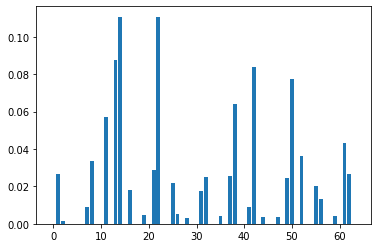

In [208]:
import matplotlib.pyplot as plt
prob=np.conjugate(final_state.data)*final_state.data

plt.bar(np.arange(prob.shape[0]),prob)
plt.show()

# convert into the single particle state
single_particle_vector=np.zeros(n_sites,dtype=np.complex128)

for a in range(n_sites):
    a_mb=2**a
    single_particle_vector[a]=final_state.data[a_mb]



In [209]:
print(np.linalg.norm(single_particle_vector))
print(np.linalg.norm(final_state.data))

0.32342941816803605
1.0000000000000078
